In [2]:
# unset PYTHONPATH first
from ko_text import *
from ko_crawler import *

import ast

In [3]:
nlp = NLP()

# 불러오기

In [4]:
token_df = pd.read_csv('Data/meta_morphs_final.csv', encoding = 'utf-8')

# 용량을 줄이기 위해 '단어 단어' 꼴로 묶어둔 token을 ['단어', '단어'] 꼴로 풀기
token_df['Token'] = [token.split() for token in token_df['Token']]

In [5]:
token_df.head()

,Section,Text,Token,Num of Tokens
0,financial,\n\n\n텀블벅에서 크라우드 펀딩이 이뤄지고 있는 `아침달 시집`.\n\n ...,"[텀블벅, 크라, 우드, 펀딩, 이뤄지고, 아침, 시집, 많지, 않은, 금액, 으로...",263
1,economy,\n\n\n[사진 제공: 연합뉴스]\n\n 유류...,"[유류, 인하, 국제, 유가, 급락, 입어, 국내, 휘발유, 경유, 하락, 특히, ...",166
2,financial,부득이한 사정으로 매월 내는 보험료가 부담이 될 때 계약은 그대로 유지하면서 보험...,"[부득이, 사정, 매월, 내는, 보험료, 부담, 계약, 그대로, 유지, 보험료, 부...",314
3,estate,한때 `미분양의 늪`으로 통하던 경기도 파주시 부동산 시장이 달라지고 있다. 지난해...,"[한때, 미분, 하던, 경기도, 파주시, 부동산, 시장, 달라지고, 분양, 파주, ...",165
4,economy,\n\n\n인디고뱅크의 `미키인서울` 컬래버 맨투맨 <사진제공=월트디즈니코리아>\...,"[인디고, 뱅크, 미키, 서울, 컬래버, 투맨, 월트디즈니, 사의, 마스코트, 미키...",196


In [6]:
token_df.shape

(41418, 4)

# **Word2Vec + CNN**

In [7]:
from gensim.models import Word2Vec

class Word2VecCNN():
    
    def __init__(self, path_to_word2vec_model = ''):
        print('초기 세팅을 시작합니다.')
        print('사전에 학습된 Word2Vec 모델을 불러옵니다.')
        try: 
            self.w2v_model = Word2Vec.load(path_to_word2vec_model)
            print('학습된 Word2Vec 모델을 성공적으로 불러왔습니다.')
            
        except : 
            self.w2v_model = Word2Vec(min_count = 1)
            print('Word2Vec 모델을 불러오는데 실패하였습니다.')
            print('=================================================================================')
            print('Default 세팅의 Word2Vec 모델을 새롭게 생성합니다.')
            print('Process 진행에 앞서, Word2Vec 모델의 학습이 필요합니다.')
            print('bulid_and_train_w2v_model 함수를 사용하여, word2vec 모델을 학습하시기 바랍니다')
            print('=================================================================================')
            print('Word2Vec의 Hyperparameter 튜닝을 원하신다면 self.w2v_model을 새롭게 생성한 모델로 덮어 쓰시면 됩니다. ')
    
    
    
    
    def build_and_train_w2v_model(self, token_ls):
        '''
        Word2Vec 모델을 학습하는 함수입니다.
        
        #inputs   
        token_ls : iterable, 문서가 토큰으로 구부된 형태로 저장된 리스트
        
        #return
        모델 학습
        '''
        import logging
        #logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

        self.w2v_model.build_vocab(token_ls)

        self.w2v_model.train(token_ls,
                            total_examples = self.w2v_model.corpus_count,
                            epochs = 10)
    
    
    
    
    def load_w2v_model(self, path_to_model):
        '''
        사전에 학습한 Word2Vec 모델을 불러오는 함수입니다.
        '''
    
        self.w2v_model = Word2Vec.load(path_to_model)
        return
    
    
    
    
    def generate_equal_sequence_doc_vector_for_cnn(self, doc, sequence_length = 10):
        '''
        CNN 학습을 위해, 모든 문서의 token 길이를 동일한 값(sequence_length)로 맞춰주는 함수입니다,
        한 개의 문서(token list)를 Word2Vec으로 벡터화하여, CNN학습에 적합한 4D로 변환합니다.
        문서의 토큰 수가 sequence_length보다 적은 경우, 부족한 만큼 zero padding을 추가합니다.

        input
        doc : iterable, 토큰으로 구분된 array 형태의 문서
        w2v_model : word2vec_model, 개별 토큰을 벡터화하기 위한 word2vec 모델
        sequence_length : int, 한 문서 당, 최대 토큰의 수
        '''
        n_dim = self.w2v_model.vector_size
        
        if len(doc) < 1:
            return np.zeros((sequence_length,self.w2v_model.vector_size)).reshape(sequence_length, n_dim, -1)

        elif len(doc) < sequence_length:
            # 해당 단어가 w2v 모델에 있으면, 해당 벡터 값으로, 없으면 0벡터로 변환
            return_array = np.array([self.w2v_model.wv.__getitem__(token) if self.w2v_model.wv.__contains__(token) else [0] * n_dim for token in doc])

            # 길이가 짧은 문서는 0백터로 max_len의 크기에 맞도록 패딩을 해준다.
            n_padding = sequence_length - len(doc)
            return_array = np.concatenate((return_array, np.zeros((n_padding, n_dim))))


        # 문서의 길이가 max_length보다 길면 앞에서 max_length의 토큰까지 짜른다.
        elif len(doc) >= sequence_length:
            # 해당 단어가 w2v 모델에 있으면, 해당 벡터 값으로, 없으면 0벡터로 변환
            return_array = np.array([self.w2v_model.wv.__getitem__(token) if self.w2v_model.wv.__contains__(token) else [0] * n_dim for token in doc[:sequence_length]])
        
        return return_array.reshape(sequence_length, n_dim,-1)
    
    
    
    
    def generate_equal_sequence_doc_vectors_for_cnn(self, doc_ls, sequence_length = 10):
        '''
        복수 개의 문서(token list)를 Word2Vec으로 벡터화하여, CNN학습에 적합한 4D로 변환하는 함수입니다.

        input
        doc_ls : iterable, 토큰으로 구분된 array 형태의 문서가 저장된 리스트
        sequence_length : int, 한 문서 당, 최대 토큰의 수
        '''
        
        return np.array([self.generate_equal_sequence_doc_vector_for_cnn(doc, sequence_length) for doc in doc_ls])
    
    
    
    
        
    def _init_weights(self,shape):
        '''
        CNN 학습을 위해, filter의 초기 weight를 주는 함수입니다.

        inputs 
        shape = 4D-array, [batch, n_height, n_width, n_channel] 
        '''
        return tf.Variable(tf.random_normal(shape, stddev=0.01))




In [8]:
w2v_cnn = Word2VecCNN('word2vec_model/w2v_model')

초기 세팅을 시작합니다.
사전에 학습된 Word2Vec 모델을 불러옵니다.
학습된 Word2Vec 모델을 성공적으로 불러왔습니다.


In [8]:
w2v_cnn.w2v_model = Word2Vec(min_count = 3, 
                             window = 5,
                             sample = 1e-5,
                             size = 100,
                             sg = 1,
                             hs = 1,
                             iter = 10,)

In [10]:
w2v_cnn.build_and_train_w2v_model(token_df['Token'].tolist())

In [9]:
w2v_cnn.w2v_model.most_similar('인공')

[('지능', 0.9047563672065735),
 ('AI', 0.781221330165863),
 ('사물인터넷', 0.7645171880722046),
 ('빅데이터', 0.752155601978302),
 ('자연어', 0.707003116607666),
 ('음성인식', 0.6939876079559326),
 ('기반', 0.6844821572303772),
 ('인텔리전스', 0.6840516328811646),
 ('기술', 0.6840213537216187),
 ('최적화', 0.6824502944946289)]

In [10]:
w2v_cnn.w2v_model.most_similar('트럼프')

[('도널드', 0.9513905048370361),
 ('행정부', 0.8262176513671875),
 ('백악관', 0.808573305606842),
 ('대통령', 0.7891108989715576),
 ('워싱턴포스트', 0.7868554592132568),
 ('WP', 0.7828512787818909),
 ('중간', 0.7472510933876038),
 ('이뤄졌다는데', 0.7459768652915955),
 ('미국', 0.7260775566101074),
 ('하원', 0.6922484636306763)]

In [13]:
#모델 저장
w2v_cnn.w2v_model.save('word2vec_model/w2v_model')

## 학습을 위한 데이터 전처리

# Train Test Split

In [11]:
train_size = round(len(token_df) * 0.8)
np.random.seed(0)
train_index_ls = np.random.choice(token_df.index, train_size, replace = False)
test_index_ls = [x for x in token_df.index if not x in train_index_ls]

In [12]:
train_df = token_df.loc[train_index_ls]
train_df.shape

(33134, 4)

In [13]:
test_df = token_df.loc[test_index_ls]
test_df.shape

(8284, 4)

In [14]:
Counter(train_df['Section'])

Counter({'bio & tech': 1739,
         'business': 4863,
         'culture & art': 4102,
         'economy': 2608,
         'estate': 3932,
         'financial': 746,
         'it': 1742,
         'politics': 3775,
         'society': 3356,
         'stock': 2508,
         'world': 3763})

In [15]:
train_token_ls = train_df['Token'].tolist()
train_label_ls = train_df['Section'].tolist()

test_token_ls = test_df['Token'].tolist()
test_label_ls = test_df['Section'].tolist()

train_token_ls, train_label_ls = nlp.oversample_batch(train_token_ls, train_label_ls, 1000)
test_token_ls, test_label_ls = nlp.undersample_batch(test_token_ls, test_label_ls, 100)

In [16]:
Counter(train_label_ls)

Counter({'bio & tech': 1000,
         'business': 1000,
         'culture & art': 1000,
         'economy': 1000,
         'estate': 1000,
         'financial': 1000,
         'it': 1000,
         'politics': 1000,
         'society': 1000,
         'stock': 1000,
         'world': 1000})

In [17]:
Counter(test_label_ls)

Counter({'bio & tech': 100,
         'business': 100,
         'culture & art': 100,
         'economy': 100,
         'estate': 100,
         'financial': 100,
         'it': 100,
         'politics': 100,
         'society': 100,
         'stock': 100,
         'world': 100})

# Word2Vec으로 문서 벡터화


In [18]:
sequence_length = 100

In [19]:
train_X_word2vec = w2v_cnn.generate_equal_sequence_doc_vectors_for_cnn(train_token_ls, sequence_length=sequence_length)
test_X_word2vec = w2v_cnn.generate_equal_sequence_doc_vectors_for_cnn(test_token_ls, sequence_length=sequence_length)

train_Y = pd.get_dummies(train_label_ls).values.astype('float32')
test_Y = pd.get_dummies(test_label_ls).values.astype('float32')

In [20]:
train_X_word2vec.shape, test_X_word2vec.shape

((11000, 100, 100, 1), (1100, 100, 100, 1))

In [21]:
n_dim = train_X_word2vec.shape[2]
n_class = len(set(test_label_ls))

# **DM + DBOW**

## **1. DM, DBOW 모델 불러오기**

In [22]:
dm = NLP()
dbow = NLP()

# 가장 성능이 좋았던 모델들 호출
dm.load_Doc2Vec_model('Doc2Vec_model/Doc2Vec_dm=True&cc=42331&vs=100&win=5&min=1&sample=1e-06&epochs=10')
dbow.load_Doc2Vec_model('Doc2Vec_model/Doc2Vec_dm=False&cc=41418&vs=100&win=5&min=1&sample=1e-06&epochs=10')

## DM-DBOW 모델로 문서 벡터화

In [23]:
# 벡터화
train_X_dm = np.array(dm.infer_vectors_with_Doc2Vec(train_token_ls, alpha = 0.05, steps = 50))
test_X_dm = np.array(dm.infer_vectors_with_Doc2Vec(test_token_ls, alpha = 0.05, steps = 50))

train_X_dbow = np.array(dbow.infer_vectors_with_Doc2Vec(train_token_ls, alpha = 0.05, steps = 50))
test_X_dbow = np.array(dbow.infer_vectors_with_Doc2Vec(test_token_ls, alpha = 0.05, steps = 50))

In [25]:
print(train_X_dm.shape)

(11000, 100)


# Word2Vec + Doc2Vec + CNN 

In [26]:
import tensorflow as tf

In [37]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))


tf.reset_default_graph()

def graph(X_word2vec,
          X_dm,
          X_dbow,
          p_keep_conv, 
          p_keep_hidden, 
          filter_size_ls = [2,3,4,5], 
          num_filter = 100, 
          sequence_length = sequence_length,
          n_fc = 500, 
          n_class= n_class,
          n_dim = n_dim):

    max_pool_result_ls = []
    
    # 각각의 사이즈의 필터를 num_filter개 생성하여 convolution & max_pool
    for filter_size in filter_size_ls:

        filter_ = init_weights([filter_size, n_dim, 1, num_filter])
        
        
        # l1_conv shape=(?, sequence_length - filter_size + 1, n_dim, num_filter)
        l1_conv = tf.nn.relu(tf.nn.conv2d(input = X_word2vec,
                                      filter = filter_,  
                                      strides=[1, 1, 1, 1], 
                                      padding='VALID')) 
        
        # l1_pool shape=(?, 1, 1, num_filter)
        l1_pool = tf.nn.max_pool(l1_conv, 
                            ksize=[1, sequence_length - filter_size + 1, 1, 1], 
                            strides=[1, 1, 1, 1], 
                            padding='VALID')

        l1_pool = tf.nn.dropout(l1_pool, p_keep_conv)

        max_pool_result_ls.append(l1_pool)

    # 각기 다른 종류의 필터를 거쳐 conv-pool한 결과를 concat (word2vec)
    num_filter_total = num_filter * len(filter_size_ls)
    max_pool_concat = tf.concat(max_pool_result_ls, 3)
    max_pool_concat_flat = tf.reshape(max_pool_concat, [-1, num_filter_total])

    
    # Doc2Vec으로 추정한 벡터와 max_pool result를 concat
    X_dm = tf.reshape(X_dm, [-1, X_dm.shape[1]])
    X_dbow = tf.reshape(X_dbow, [-1, X_dm.shape[1]])
    concat_flat = tf.concat([X_dm, X_dbow, max_pool_concat_flat], axis = 1)
    #print(concat_flat.shape[1])
    
    # fully-connect
    w_fc = init_weights([int(concat_flat.shape[1]), n_fc])
    w_output = init_weights([n_fc, n_class])

    logit = tf.nn.relu(tf.matmul(concat_flat, w_fc))
    logit = tf.nn.dropout(logit, p_keep_hidden)
    logit = tf.matmul(logit, w_output) + b
    
    hypothesis = tf.nn.softmax(logit)
    return logit, hypothesis



In [38]:
sequence_length = sequence_length
n_class = train_Y.shape[1]

batch_size = 100
test_size = 300


In [39]:
X_word2vec = tf.placeholder("float", [None, sequence_length, w2v_cnn.w2v_model.vector_size, 1])
X_dm = tf.placeholder("float", [None, train_X_dm.shape[1]])
X_dbow = tf.placeholder("float", [None, train_X_dbow.shape[1]])
Y = tf.placeholder("float", [None, n_class])

b = init_weights([n_class])

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
logit, hypothesis = graph(X_word2vec, 
                          X_dm,
                          X_dbow,
                          p_keep_conv, p_keep_hidden, sequence_length= sequence_length, n_class = n_class)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=Y))
train = tf.train.AdamOptimizer(0.0003).minimize(cost)
predict = tf.argmax(hypothesis, 1)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y,1), predict), dtype= tf.float32))


In [ ]:
training_epoch = 100

# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()
    train_cost_ls = []
    test_cost_ls = []
    
    for i in range(training_epoch):
        training_batch = zip(range(0, len(train_X_word2vec), batch_size),
                             range(batch_size, len(train_X_word2vec)+1, batch_size))
        
        for start, end in training_batch:
            sess.run(train, 
                     feed_dict={X_word2vec: train_X_word2vec[start:end], 
                                X_dm : train_X_dm[start:end],
                                X_dbow : train_X_dbow[start:end],
                                Y: train_Y[start:end],
                                p_keep_conv: 0.5, 
                                p_keep_hidden: 0.5})
        
        
        test_indices = np.arange(len(test_X_word2vec)) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]
        
        train_dict = {X_word2vec: train_X_word2vec[test_indices],
                      X_dm: train_X_dm[test_indices],
                      X_dbow: train_X_dbow[test_indices],
                      Y: train_Y[test_indices],
                      p_keep_conv: 1.0,
                      p_keep_hidden : 1.0}
        
        test_dict = {X_word2vec: test_X_word2vec,
                    X_dm: test_X_dm,
                    X_dbow: test_X_dbow,
                    Y: test_Y,
                    p_keep_conv: 1.0,
                    p_keep_hidden : 1.0}
        
        train_cost = sess.run(cost, feed_dict= train_dict)
        train_cost_ls.append(train_cost)
        
        test_cost, acc = sess.run([cost, accuracy], feed_dict=  test_dict)
        test_cost_ls.append(test_cost)
                            
        print('Epoch : %s, train_cost : %s, test_cost : %s'%(i,round(train_cost, 3), round(test_cost,3)))
        print('Accuracy : %s'%acc)

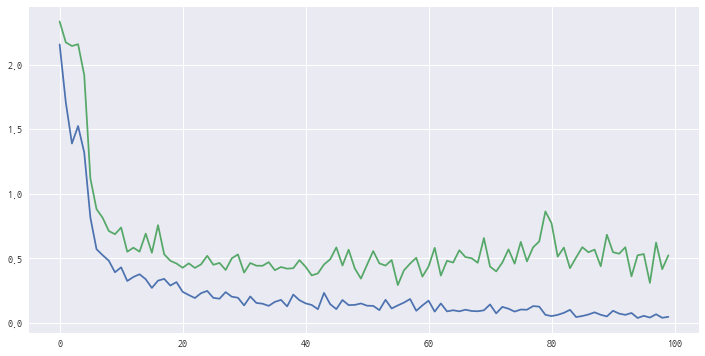

In [41]:
plt.figure(figsize = (12,6))
plt.plot(train_cost_ls, label = 'train cost')
plt.plot(test_cost_ls, label = 'test cost')